# Understanding gaussian processes

## Brief introduction

According to Wikipedia's entry on Gaussian Processes (GP): 

> a **Gaussian process** is a stochastic process (a collection of random variables indexed by time or space), such that every finite collection of those random variables has a multivariate normal distribution, i.e. every finite linear combination of them is normally distributed. The distribution of a Gaussian process is the joint distribution of all those (infinitely many) random variables, and as such, it is a distribution over functions with a continuous domain, e.g. time or space

Now all that means is that it is a random process where all of the points are related to each other in a way that can be defined by a covariance matrix. What is nice about Gaussian processes is that they can be used to model functions without knowing exactly what their functional forms should be, so that estimates of functional value (and uncertainty!) can be made. 

If you are interested in a deeper dive into the theory behind GP's the go-to reference is Rasmussen & Williams "Gaussian Processes for Machine Learning" (which they provide free online [here](http://www.gaussianprocess.org/gpml/chapters/RW.pdf)).

A briefer, beginner-friendly tutorial can also be found in Eric Schulz's ["A tutorial on Gaussian process regression: Modelling, exploring, and exploiting functions"](https://ericschulz.github.io/publications/Schulz2017tutorial.pdf). This notebook is very largely based off of information found in this reference.

The point of this notebook is to go through the mathematics behind drawing random GP's instead of just calling a random package and having the results get shoved in front of me like I'm some sort of GP magician.

So, let us start, as always in Python, with importing the necessary packages.

In [1]:
#importing necessary packages
import numpy as np #for vector manipulation
from numpy.random import normal, seed, uniform #for drawing random values and setting the random seed
from scipy.optimize import minimize #for optimizing the log likelihood (in the later regression steps)
from scipy.special import gamma, kv #for matern kernel
import matplotlib.pyplot as plt #for plotting

#show plots in cells
%matplotlib inline 

#Setting a random seed so final results can be reproduced
seed(2)

## Choosing a kernel

Now that we have those, we need to define some kernel functions. The kernel function defines how correlated points are to each other based on their position. Or, in other words, gives a measure of the similarity between points. In all of the following, $\vec{\textbf{x}}$ is the domain vector of a single data point. These kernel functions are all evaluated many times to create the full covariance matrix.

The most basic kernels produce GPs of a familiar form. For example, creating a linear function.

Linear:
$$k_{L}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma_b^2\vec{\textbf{x}}^{T}\vec{\textbf{x}}^{\prime} + \sigma_a^2$$

Other, more useful kernels can replicate more complex behaviors. In all of the following, $\sigma$ descibes the amplitude of the GP while $\lambda$ describes the typical timescale (aka the length of the 'wiggles' in your function). Using $d$ as the distance between points, here are some common kernels.

$$d(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime}) = |\vec{\textbf{x}}-\vec{\textbf{x}}^{\prime}|$$

Radial Basis Function Kernel (Squared Exonential):
$$k_{RBF}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2 \exp\left(-\frac{d^2}{2 \lambda^2}\right)$$
Most common kernel function. Used for smoothly varying functions.

Ornstein–Uhlenbeck (Exponential):
$$k_{OU}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\exp\left(-\frac{d}{\lambda}\right)$$

Matern:
$$k_{Matern}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2\nu} \ d}{\lambda}\right)^{\nu}K_{\nu}\left(\frac{\sqrt{2\nu} \ d}{\lambda}\right)$$
where $K_{\nu}$ is the modified Bessel function of order $\nu$ and $\Gamma(\nu)$ is the gamma function evaluated at $\nu$. Common values of $\nu$ are 3/2 and 5/2.

Periodic:
$$k_{P}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\exp\left(-\frac{2 \sin^2\left(\frac{\pi d}{P}\right)}{\lambda^2}\right)$$
Used for periodic functions.

Rational Quadratic:
$$k_{RQ}(\vec{\textbf{x}},\vec{\textbf{x}}^{\prime})=\sigma^2\left(1+\frac{d^2}{2 \alpha \lambda^2}\right)^{-\alpha}, \alpha \ge 0$$
Used for functions with many timescales.

Technically, a valid kernel function has to be a "positive-definite function". While I won't go into what that actually means, I will say that when  positive-definite functions are added or multiplied together, they create more positive-definite functions, so any of the above kernels can be added or multiplied together to create more complicated kernels (see some examples in the defined kernel function).

If you want to learn more about kernels and how to choose them, you can read David Duvenaud's [Kernel Cookbook](http://www.cs.toronto.edu/~duvenaud/cookbook/index.html)

In [2]:
#Linear kernel
def linear_kernel(hyperparameters,x1,x2):
    
    sigma_b, sigma_a = hyperparameters
    return sigma_b**2*np.dot(x1,x2)+ sigma_a**2

#Radial basis function kernel(aka squared exonential, ~gaussian)
def RBF_kernel(hyperparameters,dif_sq):
    
    kernel_amplitude, kernel_length = hyperparameters
    return kernel_amplitude**2*np.exp(-dif_sq/(2*kernel_length**2))

#Ornstein–Uhlenbeck (Exponential) kernel
def OU_kernel(hyperparameters,dif):
    
    kernel_amplitude, kernel_length = hyperparameters
    return kernel_amplitude**2*np.exp(-dif/(kernel_length))

#Periodic kernel
def periodic_kernel(hyperparameters,dif):
    
    kernel_amplitude, kernel_length, kernel_period = hyperparameters
    return kernel_amplitude**2*np.exp(-2*np.sin(np.pi*dif/kernel_period)**2/(kernel_length**2))

#Matern kernel (not sure if I implemented this correctly. Gets nans when dif==0)
def Matern_kernel(hyperparameters,dif,nu):
    
    kernel_amplitude, kernel_length = hyperparameters
    if dif==0:
        return kernel_amplitude**2
    else:
        return kernel_amplitude**2*((2**(1-nu))/(gamma(nu)))*((np.sqrt(2*nu)*dif)/(kernel_length))**nu*kv(nu,(np.sqrt(2*nu)*dif)/(kernel_length))

#Rational Quadratic kernel (equivalent to adding together many SE kernels 
#with different lengthscales. When α→∞, the RQ is identical to the SE.)
def RQ_kernel(hyperparameters,dif_sq):
    
    kernel_amplitude, kernel_length, alpha = hyperparameters
    alpha=max(alpha,0)
    return kernel_amplitude**2*(1+dif_sq/(2*alpha*kernel_length**2))**-alpha

#Creating a custom kernel (possibly by adding and multiplying other kernels?)
def kernel(hyperparameters,x1,x2):
        
    #converting inputs to arrays and finding their squared differences
    x1a=np.array(x1)
    x2a=np.array(x2)
    dif_vec=x1a-x2a
    dif_sq=np.dot(dif_vec,dif_vec)
    dif=np.sqrt(dif_sq)
    
    # final = RBF_kernel(hyperparameters,dif_sq) 
    # final = OU_kernel(hyperparameters,dif) 
    # final = linear_kernel(hyperparameters,x1a,x2a)
    final = periodic_kernel(hyperparameters,dif)
    # final = RQ_kernel(hyperparameters,dif_sq)
    # final = Matern_kernel(hyperparameters,dif,3/2) #doesn't seem to be working right now
    
    #example of adding kernels
    # final = periodic_kernel(hyperparameters[0:3],dif)+RBF_kernel(hyperparameters[3:5],dif_sq)
    
    #example of multiplying kernels
    # final = periodic_kernel(hyperparameters[0:3],dif)*RBF_kernel(hyperparameters[3:5],dif_sq)

    return final

## Creating a covariance matrix

Now that we've chosen (or constructed) our kernel, we have to use it to calculate how similar each of the points are to each other. Python is not always the most elegant, so I created a function to do this with two for loops.

In [3]:
#Creates the covariance matrix by evaluating the kernel function for each pair of passed inputs
def covariance(x1list,x2list,hyperparameters):
    K=np.zeros((len(x1list),len(x2list)))
    for i, x1 in enumerate(x1list):
        for j, x2 in enumerate(x2list):
            K[i,j]=kernel(hyperparameters,x1,x2)
    return K

Now lets try out some values for our hyperparameters and calculate the covariance matrix for throughout the input domain!

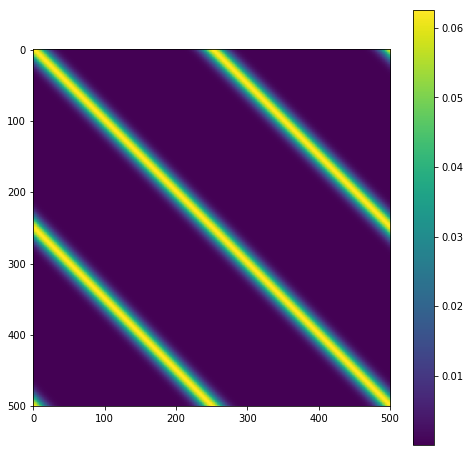

In [4]:
#kernel hyper parameters (AFFECTS SHAPE OF GP's, make sure you have the right amount!)
#just some starting values, see each kernel for what these mean
# hyperparameters = [0.8, 0.3, 2 ,0.5, .3]
hyperparameters = [0.25, 0.3, 4] 

#how finely to sample the domain
GP_sample_amount=500+1

#creating many inputs to sample the eventual gaussian process on
domain=8 #how wide the measurement domain is
x_samp=np.linspace(0,domain,GP_sample_amount)

#Finding how correlated the sampled inputs are to each other
#(aka getting the covariance matrix by evaluating the kernel function at all pairs of points)
K_samp=covariance(x_samp,x_samp,hyperparameters)        

#plot the evaluated covariance matrix (colors show how correlated points are to each other)
plt.figure(figsize=(8,8))
plt.imshow(K_samp)
plt.colorbar()
plt.show()

## Drawing our first processes

Okay, we have our covariance matrix and are finally ready to draw some sweet sweet random squiggly lines. 

The covariance matrix shows the multivariate Gaussian relationship between all of the points in the domain, so what we have to do to get some random GP curves is draw GP_sample_amount values from the normal distribution and multiply that by the covariance. 

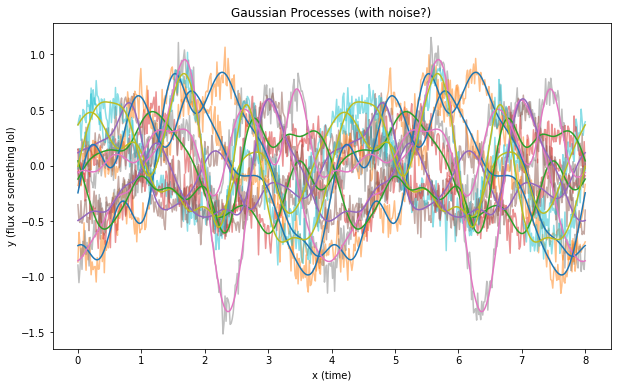

In [5]:
#noise to add to gaussians (to simulate observations)
GP_noise=.1

#how many GPs to plot
amount_of_GPs=10

#plotting amount_of_GPs randomly drawn Gaussian processes using the kernel function to correlate points
plt.figure(figsize=(10,6))
for i in range(amount_of_GPs):
    
    #sampled possible GP function values
    GP_func=np.matmul(K_samp,normal(size=GP_sample_amount)) 
    plt.plot(x_samp,GP_func, zorder=2)
    
    #sampled possible GP observations (that have noise)
    GP_obs=GP_func+GP_noise*normal(size=GP_sample_amount) 
    plt.plot(x_samp,GP_obs, alpha=0.5, zorder=1)
    
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (with noise?)")
plt.show()

# MAGIC!!!

I still haven't gotten over that you can create infinitely many weird squiggles of a characteristic shape yet.

## Conditioning our model with data

We've created some squiggles, but now we want to see which squiggles make sense with the "data" we have. So let's create some data and see if we can make the squiggles comply.

I've written a sample function to generate observed data (currently a noisy sine function) already. Now we can just specify the amount of measurements and the noise that goes along with them and we can go from there.

In [6]:
#"true" underlying function for the fake observations
def observations(x,measurement_noise):
    
    #a phase shifted sine curve with noise
    shift = uniform(high=2*np.pi)
    return np.sin(np.pi/2*x+shift)+np.multiply(np.square(measurement_noise),normal(size=len(x)))

#creating observations to test methods on
amount_of_measurements=25

#Uncertainty in the data (AFFECTS SPREAD OF DATA AND HOW TIGHTLY THE GP's WILL TRY TO HUG THE DATA)
#aka how much noise is added to measurements and measurement covariance function
#can be a list (length=amount_of_measurements) or single number
measurement_noise=0.3

#make measurement noise into an array (for my convenience)
measurement_noise = np.ndarray.flatten(np.array([measurement_noise]))
if len(measurement_noise)==1:
    measurement_noise=np.ones(amount_of_measurements)*measurement_noise[0]

x_obs=domain*uniform(size=amount_of_measurements) #observation inputs
y_obs=observations(x_obs,measurement_noise) #observation outputs

We have our data, now lets see how good these GPs look!!!

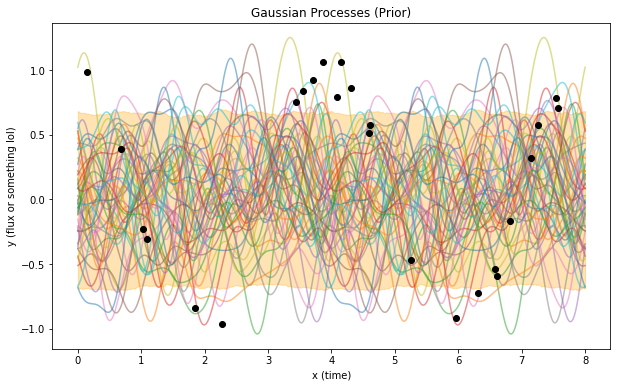

In [7]:
#plotting some more randomly drawn Gaussian processes before data influences the posterior
plt.figure(figsize=(10,6))
draws=5000
show=50
storage=np.zeros((draws,GP_sample_amount))
#drawing lots of GPs (to get a good estimate of 5-95th percentile.
#Haven't found the analytical way to do it
for i in range(draws):
    storage[i,:]=np.matmul(K_samp,normal(size=GP_sample_amount))
    # plt.plot(x_samp,test[i,:], alpha=0.5, zorder=1)
#only showing some
for i in range(show):
    plt.plot(x_samp,storage[i,:], alpha=0.5, zorder=1)
#filling the 5-95th percentile with a transparent orange
storage=np.sort(storage,axis=0)
plt.fill_between(x_samp, storage[int(0.95*draws),:], storage[int(0.05*draws),:], alpha=0.3, color='orange')
#plt.plot(x_samp,np.matmul(K_post,np.ones(GP_sample_amount)*1.95)+mean_post, color="black", zorder=2)
#plt.plot(x_samp,np.matmul(K_post,np.ones(GP_sample_amount)*-1.95)+mean_post, color="black", zorder=2)
plt.scatter(x_obs,y_obs,color="black",zorder=2)
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (Prior)")
plt.show()

Hmmmm well they don't look so good yet, but we haven't used our data yet to find the conditional distribution of funtion values yet. This process is a little opaque and takes a long time staring at equations and doing linear algebra, but for this tutorial we are just going to look at and calculate examples of the results which are shown in pages 13-15 of [Eric Schulz's tutorial](https://ericschulz.github.io/publications/Schulz2017tutorial.pdf).

This cell calculates the mean function and covariance for the posterior GP.

In [8]:
#creating additional covariance matrices (as defined on pages 13-15 of Eric Schulz's tutorial)
noise_I=np.square(measurement_noise)*np.identity(amount_of_measurements)
K_obs=covariance(x_obs,x_obs,hyperparameters)+noise_I
K_samp_obs=covariance(x_samp,x_obs,hyperparameters) 
K_obs_samp=covariance(x_obs,x_samp,hyperparameters)

#mean of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
mean_post=np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),y_obs))
#covariance matrix of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
K_post=K_samp-np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),K_obs_samp))

With the linear algebra out of the way, lets plot the new covariance and mean function! 
Spoiler alert: it's way better.

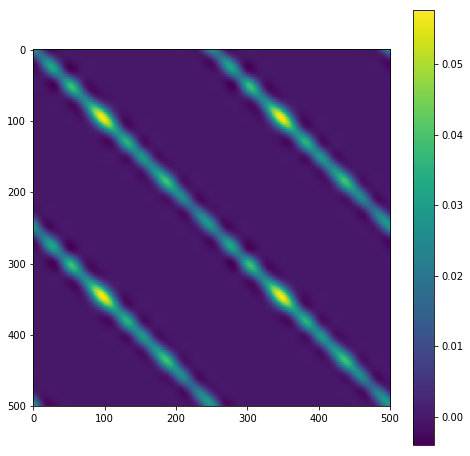

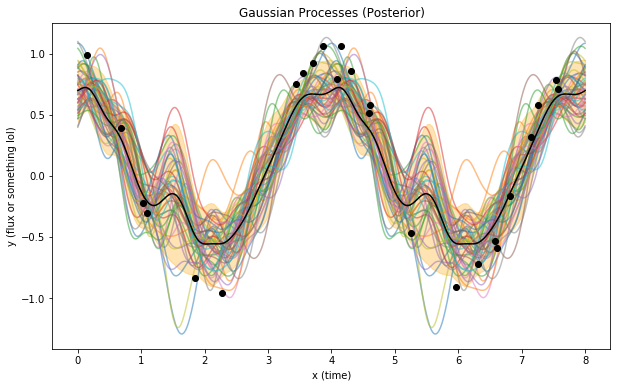

In [9]:
#plot the posterior covariance matrix (colors show how correlated points are to each other)
plt.figure(figsize=(8,8))
plt.imshow(K_post)
plt.colorbar()
plt.show()

#plotting randomly drawn Gaussian processes with the mean function and covariance of the posterior
#much closer to the data, no?
plt.figure(figsize=(10,6))
draws=5000
show=50
storage=np.zeros((draws,GP_sample_amount))
#drawing lots of GPs (to get a good estimate of 5-95th percentile.
#Haven't found the analytical way to do it
for i in range(draws):
    storage[i,:]=np.matmul(K_post,normal(size=GP_sample_amount))+mean_post
    # plt.plot(x_samp,test[i,:], alpha=0.5, zorder=1)
#only showing some
for i in range(show):
    plt.plot(x_samp,storage[i,:], alpha=0.5, zorder=1)
#filling the 5-95th percentile with a transparent orange
storage=np.sort(storage,axis=0)
plt.plot(x_samp,mean_post, color="black", zorder=2)
plt.fill_between(x_samp, storage[int(0.95*draws),:], storage[int(0.05*draws),:], alpha=0.3, color='orange')
#plt.plot(x_samp,np.matmul(K_post,np.ones(GP_sample_amount)*1.645/np.sqrt(GP_sample_amount))+mean_post, color="black", zorder=2)
#plt.plot(x_samp,np.matmul(K_post,np.ones(GP_sample_amount)*-1.645/np.sqrt(GP_sample_amount))+mean_post, color="black", zorder=2)
plt.scatter(x_obs,y_obs,color="black",zorder=2)
#plt.ylim(ymin, ymax)
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (Posterior)")
plt.show()

## Choosing hyperparameters

So we just showed how to condition a GP with a specific kernel and set of hyperparameters with observed data, but how does one find the best hyperparameters?

from [Eric Schulz's tutorial](https://ericschulz.github.io/publications/Schulz2017tutorial.pdf):

> As the posterior distribution over the hyper-parameters is non-trivial to obtain, full Bayesian inference of the hyper-parameters is not frequently used in practice. Instead, common practice is to obtain point estimates of the hyper-parameters by maximising the marginal (log) likelihood.

The worst part of any maximum likelihood estimation is usually finding and writing down the likelihood. Luckily, someone else has done it for us. The log marginal likelihood of the outputted measurements given the measurment inputs and hyperparameters is as follows (as seen on page 19):

$$\log p(\textbf{y}|\textbf{X},\boldsymbol{\theta})=-\frac{1}{2} \textbf{y}^T \textbf{K}_y^{-1} \textbf{y} -\frac{1}{2} \log|\textbf{K}_y| - \frac{n}{2} \log (2 \pi)$$

to paraphrase the tutorial

>$\textbf{K}_y$ is the covariance matrix of the noisy output values. The marginal log likelihood can be viewed as a penalized fit measure, where $-\frac{1}{2} \textbf{y}^T \textbf{K}_y^{-1} \textbf{y}$ measures the data fit, $-\frac{1}{2} \log|\textbf{K}_y|$ is a complexity penalization term, and $- \frac{n}{2} \log (2 \pi)$ is a normalization constant.

This is normally optimized numerically, here done with scipy's minimize function. Hopefully our "Optimization terminates successfully."

In [10]:
#negative log likelihood of the data given the current kernel parameters (as seen on page 19)
#(negative because scipy has a minimizer instead of a maximizer)
def nlogL(hyperparameters):
    n=len(y_obs)
    
    noise_I=np.square(measurement_noise)*np.identity(amount_of_measurements)
    K_obs=covariance(x_obs,x_obs,hyperparameters)+noise_I
    
    #goodness of fit term
    data_fit=-1/2*np.matmul(np.transpose(y_obs),np.matmul(np.linalg.inv(K_obs),y_obs))
    #complexity penalization term
    penalty=-1/2*np.log(np.linalg.det(K_obs))
    #normalization term (functionally useless)
    normalization=-n/2*np.log(2*np.pi)
    return -1*(data_fit+penalty+normalization)

#numerically maximize the likelihood to find the best hyperparameters
result=minimize(nlogL, hyperparameters)
# print(result) #uncomment this for more details
print(result.message)

Optimization terminated successfully.


Finally we've found "optimal" hyperparameters. Let's plot the new conditioned mean function and see what it looks like.

'Best-fit' hyperparameters
[1.4557052  2.83977875 4.02445843]


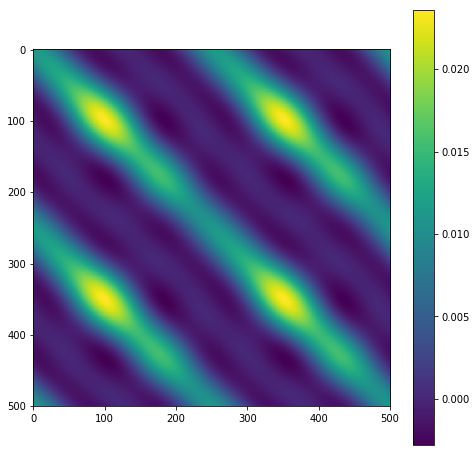

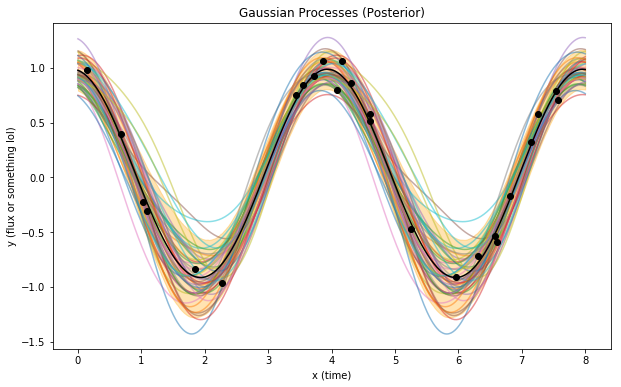

In [11]:
#reruning analysis of posterior with the "most likley" kernel amplitude and lengthscale
hyperparameters=result.x

print("'Best-fit' hyperparameters")
print(hyperparameters)

#recalculating covariance matrices
K_samp=covariance(x_samp,x_samp,hyperparameters) 
noise_I=np.square(measurement_noise)*np.identity(amount_of_measurements)
K_obs=covariance(x_obs,x_obs,hyperparameters)+noise_I
K_samp_obs=covariance(x_samp,x_obs,hyperparameters) 
K_obs_samp=covariance(x_obs,x_samp,hyperparameters)

#mean of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
mean_post=np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),y_obs))
#cavariance matrix of the conditional distribution p(f_samp|x_obs,t_obs,x_samp) (as defined on page 14)
K_post=K_samp-np.matmul(K_samp_obs,np.matmul(np.linalg.inv(K_obs),K_obs_samp))

#plot the posterior covariance of the "most likely" posterior matrix 
#(colors show how correlated points are to each other)
plt.figure(figsize=(8,8))
plt.imshow(K_post)
plt.colorbar()
plt.show()

#plotting randomly drawn Gaussian processes with the mean function and covariance of the posterior
#much closer to the data, no?
plt.figure(figsize=(10,6))
draws=5000
show=50
storage=np.zeros((draws,GP_sample_amount))
#drawing lots of GPs (to get a good estimate of 5-95th percentile.
#Haven't found the analytical way to do it
for i in range(draws):
    storage[i,:]=np.matmul(K_post,normal(size=GP_sample_amount))+mean_post
    # plt.plot(x_samp,test[i,:], alpha=0.5, zorder=1)
#only showing some
for i in range(show):
    plt.plot(x_samp,storage[i,:], alpha=0.5, zorder=1)
#filling the 5-95th percentile with a transparent orange
storage=np.sort(storage,axis=0)
plt.plot(x_samp,mean_post, color="black", zorder=2)
plt.fill_between(x_samp, storage[int(0.95*draws),:], storage[int(0.05*draws),:], alpha=0.3, color='orange')
#plt.plot(x_samp,np.matmul(K_post,np.ones(GP_sample_amount)*1.95)+mean_post, color="black", zorder=2)
#plt.plot(x_samp,np.matmul(K_post,np.ones(GP_sample_amount)*-1.95)+mean_post, color="black", zorder=2)
plt.scatter(x_obs,y_obs,color="black",zorder=2)
#plt.ylim(ymin, ymax)
plt.xlabel("x (time)")
plt.ylabel("y (flux or something lol)")
plt.title("Gaussian Processes (Posterior)")
plt.show()

Looks pretty good.

Hope this helped you figure out a bit about GPs!